In [81]:
import pyspark
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import NGram, VectorAssembler

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
#sc = SparkContext('local')
sc = SparkSession.builder.appName('spark')\
.master("spark://169.254.123.79:7077")\
.getOrCreate()

In [3]:
sc._jsc.sc().getExecutorMemoryStatus()

JavaObject id=o30

In [4]:
spark = SparkSession(sc)

In [5]:
print("SparkContext :",spark)

SparkContext : <pyspark.sql.session.SparkSession object at 0x00000255686EEAF0>


In [6]:
spark

In [7]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : 2cb96529396d93b46abab7bbc73a208e708c642e
python           : 3.8.8.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_United States.1252

pandas           : 1.2.4
numpy            : 1.22.1
pytz             : 2021.1
dateutil         : 2.8.1
pip              : 21.0.1
setuptools       : 52.0.0.post20210125
Cython           : 0.29.23
pytest           : 6.2.3
hypothesis       : None
sphinx           : 4.0.1
blosc            : None
feather          : None
xlsxwriter       : 1.3.8
lxml.etree       : 4.6.3
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.22.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck    

In [11]:
%time df_Tickets_final = pd.read_parquet('D:/datascience/support_ticket_classification/ticket.parquet',engine='pyarrow')

ImportError: Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.

In [19]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
#itTicketOthersDF = itTicketDF[itTicketDF['Assignment group'] != 'GRP_0']

descending_order = df_Tickets_final['Assignmentgroup'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignmentgroup', data=df_Tickets_final, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

NameError: name 'df_Tickets_final' is not defined

In [10]:
maxOthers = df_Tickets_final['Assignmentgroup'].value_counts().max()
maxOthers

28511

In [11]:
from sklearn.utils import resample
df_Tickets_final_resampled = df_Tickets_final[0:0]
for grp in df_Tickets_final['Assignmentgroup'].unique():
    itTicketGrpDF = df_Tickets_final[df_Tickets_final['Assignmentgroup'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers/2), random_state=123)
    df_Tickets_final_resampled = df_Tickets_final_resampled.append(resampled)

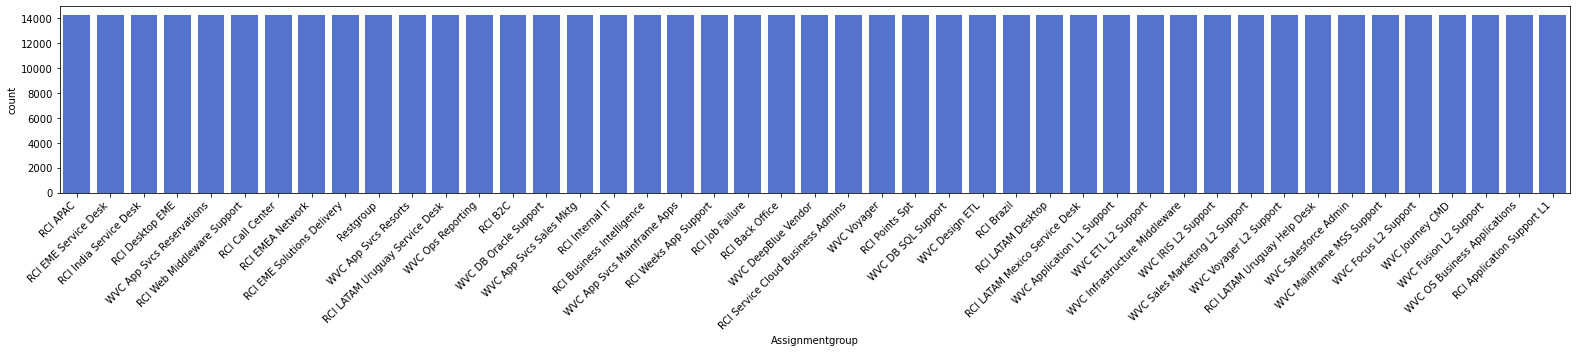

In [12]:
descending_order = df_Tickets_final_resampled['Assignmentgroup'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignmentgroup', data=df_Tickets_final_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
df_Tickets_final_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641475 entries, 145966 to 230166
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Assignmentgroup       641475 non-null  object  
 1   Description           641475 non-null  object  
 2   Cleaned_Description   641475 non-null  object  
 3   lemma_description     641475 non-null  object  
 4   final_desription      641475 non-null  object  
 5   finalRemovingPOStags  641475 non-null  object  
 6   num_words             641475 non-null  int64   
 7   bins                  636405 non-null  category
dtypes: category(1), int64(1), object(6)
memory usage: 55.9+ MB


In [13]:
#df_Tickets_final_resampled.to_parquet('D:/datascience/support_ticket_classification/ticket_over_sampled.parquet') 

In [29]:
parDF1=spark.read.parquet("D:/datascience/support_ticket_classification/ticket_over_sampled.parquet")

In [30]:
parDF1.printSchema()

root
 |-- Assignmentgroup: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Cleaned_Description: string (nullable = true)
 |-- lemma_description: string (nullable = true)
 |-- final_desription: string (nullable = true)
 |-- finalRemovingPOStags: string (nullable = true)
 |-- num_words: long (nullable = true)
 |-- bins: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [31]:
parDF1.show(5)

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-------+-----------------+
|Assignmentgroup|         Description| Cleaned_Description|   lemma_description|    final_desription|finalRemovingPOStags|num_words|   bins|__index_level_0__|
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-------+-----------------+
|       RCI APAC|Hi Team,

I just ...|hi team just did ...|hi team just did ...| team transaction...|team transaction ...|       39|  0-100|           145966|
|       RCI APAC|Unable to access ...|unable to access ...|unable to access ...| unable access gu...|        access guide|        5|  0-100|           141855|
|       RCI APAC|From: Ng Zu Yuan ...|ng zu yuan singpo...|ng zu yuan singpo...| ng zu yuan singp...|yuan singpost mai...|      148|100-300|            69388|
|       RCI APAC|Hi team,

I can't...|hi team 

In [32]:
drop_list = ['Description', 'Cleaned_Description', 'lemma_description', 'final_desription', 'num_words', 'bin', '__index_level_0__','bins']

In [33]:
parDF1 = parDF1.select([column for column in parDF1.columns if column not in drop_list])
parDF1.show(5)

+---------------+--------------------+
|Assignmentgroup|finalRemovingPOStags|
+---------------+--------------------+
|       RCI APAC|team transaction ...|
|       RCI APAC|        access guide|
|       RCI APAC|yuan singpost mai...|
|       RCI APAC|team password yes...|
|       RCI APAC|service desk rout...|
+---------------+--------------------+
only showing top 5 rows



In [13]:
parDF1.printSchema()

root
 |-- Assignmentgroup: string (nullable = true)
 |-- finalRemovingPOStags: string (nullable = true)



In [14]:
#assembler = VectorAssembler(inputCols=['finalRemovingPOStags'],outputCol='features')
#output = assembler.transform(parDF1)

#### Using Count Vector Features

In [122]:
def build_trigrams(inputCol=["finalRemovingPOStags","Assignmentgroup"], n=2):
    tokenizer = [Tokenizer(inputCol="finalRemovingPOStags", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
 
    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
 
    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "Assignmentgroup", outputCol = "label")]
     
    #lr = [LogisticRegression(maxIter=100 )]  # regParam=0.3, elasticNetParam=0.8
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx)

In [123]:
# Fit the pipeline to training documents.
pipelineFit = build_trigrams().fit(parDF1)
dataset = pipelineFit.transform(parDF1)
dataset.show(5)

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Assignmentgroup|finalRemovingPOStags|               words|             1_grams|             2_grams|                1_tf|                2_tf|             1_tfidf|             2_tfidf|            features|label|
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|       RCI APAC|team transaction ...|[team, transactio...|[team, transactio...|[team transaction...|(16384,[0,1,11,12...|(16384,[106,200,5...|(16384,[0,1,11,12...|(16384,[106,200,5...|(32768,[0,1,11,12...|  0.0|
|       RCI APAC|        access guide|     [access, guide]|     [access, guide]|      [access guide]|(16384,[38,142],[...|(16384,[8736],[1.0])|(1638

In [124]:
train, test = dataset.randomSplit([0.7, 0.3], seed=12345)

In [125]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 449054
Test Dataset Count: 192421


#### Using Logistic Regression using Trigram 

In [113]:
lr = LogisticRegression()
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

In [114]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.9114916667767864

In [115]:
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("label").collect()

In [116]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Test Precision: %.3f' % precision_score(y_orig, y_pred,average='micro'))
print('Test Recall: %.3f' % recall_score(y_orig, y_pred,average='micro'))
print('Test F1 Score: %.3f' % f1_score(y_orig, y_pred,average='micro'))

Confusion Matrix:
[[3399    0    6 ...    0    3    2]
 [   0 3793    0 ...    0    0    0]
 [  11    0 4125 ...    1    1    0]
 ...
 [   6    0    0 ... 4102    0    3]
 [   5    0    0 ...    3 3975   56]
 [   2    2    0 ...    0   47 3956]]
Test Precision: 0.911
Test Recall: 0.911
Test F1 Score: 0.911


In [117]:
 print(classification_report(y_pred,y_orig))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      3947
         1.0       0.90      0.91      0.91      4175
         2.0       0.94      0.95      0.95      4333
         3.0       0.91      0.93      0.92      4221
         4.0       0.89      0.58      0.70      6567
         5.0       0.98      0.99      0.99      4232
         6.0       0.73      0.90      0.81      3458
         7.0       0.62      0.70      0.66      3786
         8.0       0.73      0.73      0.73      4226
         9.0       0.98      0.99      0.98      4275
        10.0       0.93      0.93      0.93      4244
        11.0       0.79      0.78      0.79      4391
        12.0       0.98      0.98      0.98      4294
        13.0       0.99      0.97      0.98      4252
        14.0       1.00      0.99      0.99      4299
        15.0       0.96      0.97      0.96      4249
        16.0       0.94      0.73      0.82      5642
        17.0       0.91    

#### Using NaiveBayes 

In [126]:
nb = NaiveBayes(smoothing=1,modelType="multinomial")
model = nb.fit(train)
predictionsNB = model.transform(test)

In [127]:
evaluatorNB = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluatorNB.evaluate(predictionsNB)

0.7692513211127201

In [128]:
nbparamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
               .build())

In [129]:
# Create 5-fold CrossValidator
nbcv = CrossValidator(estimator = nb,
                      estimatorParamMaps = nbparamGrid,
                      evaluator = evaluatorNB,
                      numFolds = 5)

In [130]:
nbcvModel = nbcv.fit(train)
print(nbcvModel)
nbpredictions = nbcvModel.transform(test)

CrossValidatorModel_367135e69b74


In [131]:
print('Accuracy:', evaluatorNB.evaluate(nbpredictions))

Accuracy: 0.8056194629003494


In [135]:
y_pred=nbpredictions.select("prediction").collect()
y_orig=nbpredictions.select("label").collect()

In [136]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Test Precision: %.3f' % precision_score(y_orig, y_pred,average='micro'))
print('Test Recall: %.3f' % recall_score(y_orig, y_pred,average='micro'))
print('Test F1 Score: %.3f' % f1_score(y_orig, y_pred,average='micro'))

Confusion Matrix:
[[2976    3   64 ...   16   10    5]
 [  10 2623   25 ...    0    0    0]
 [  91    0 3787 ...    0    8    0]
 ...
 [  12    0   21 ... 3468   18   13]
 [  43    1    9 ...    8 3431  260]
 [  12    0    2 ...    3  169 3486]]
Test Precision: 0.807
Test Recall: 0.807
Test F1 Score: 0.807


#### CV and Hyperparameter tunning 

In [139]:
# Create ParamGrid for Cross Validation
evaluatorgrid = MulticlassClassificationEvaluator(predictionCol="prediction")
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [10])
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

In [140]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluatorgrid, \
                    numFolds=5)
cvModel = cv.fit(train)

Py4JJavaError: An error occurred while calling o7957.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 950.0 failed 4 times, most recent failure: Lost task 5.3 in stage 950.0 (TID 13987) (169.254.123.79 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.ml.optim.loss.RDDLossFunction.calculate(RDDLossFunction.scala:61)
	at org.apache.spark.ml.optim.loss.RDDLossFunction.calculate(RDDLossFunction.scala:47)
	at breeze.optimize.CachedDiffFunction.calculate(CachedDiffFunction.scala:24)
	at breeze.optimize.FirstOrderMinimizer.calculateObjective(FirstOrderMinimizer.scala:51)
	at breeze.optimize.FirstOrderMinimizer.initialState(FirstOrderMinimizer.scala:45)
	at breeze.optimize.FirstOrderMinimizer.iterations(FirstOrderMinimizer.scala:97)
	at org.apache.spark.ml.classification.LogisticRegression.trainImpl(LogisticRegression.scala:961)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:627)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:285)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)


In [ ]:
predictions = cvModel.transform(test)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

#### Using TF-IDF Features

In [30]:
parDF1.show(5)

+---------------+--------------------+
|Assignmentgroup|finalRemovingPOStags|
+---------------+--------------------+
|       RCI APAC|team transaction ...|
|       RCI APAC|        access guide|
|       RCI APAC|yuan singpost mai...|
|       RCI APAC|team password yes...|
|       RCI APAC|service desk rout...|
+---------------+--------------------+
only showing top 5 rows



In [ ]:
hashingTF = HashingTF(inputCol="finalRemovingPOStags", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

In [ ]:
rfc = RandomForestClassifier(numTrees=10, maxDepth=8, labelCol="label", seed=42,
    leafCol="leafId")
rfcmodel = rfc.fit(train)
predictions= rfcmodel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)